<a href="https://colab.research.google.com/github/tejusn/doc-ai-exp/blob/main/Learn_Docling_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!pip install docling

## Document Conversion

Fetch document from a source url and set it to source variable

In [2]:
from IPython.display import display
import json
import requests # Import the requests library

source_url = "https://arxiv.org/pdf/2501.17887"
local_filename = "/content/2501.17887.pdf" # Define the local filename

# Download the PDF from the URL
try:
    response = requests.get(source_url)
    response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
    with open(local_filename, 'wb') as f:
        f.write(response.content)
    source = local_filename # Update source to the local filename
    print(f"Downloaded PDF to {local_filename}")
except requests.exceptions.RequestException as e:
    print(f"Error downloading the PDF: {e}")
    source = None # Set source to None if download fails

Downloaded PDF to /content/2501.17887.pdf


In [ ]:
from docling.document_converter import DocumentConverter

if source:
    converter = DocumentConverter()
    doc = converter.convert(source).document

    # print(doc.export)
else:
    print("Could not process the document as the download failed.")
    doc = None # Set doc to None if source is not available

### Document Conversion using vLLM [Docling vision models](https://docling-project.github.io/docling/usage/vision_models/)

Extract 1 page from the whole pdf. VLLM model processing time is more hence a smaller input is recommended.

In [3]:
import pypdfium2 as pdfium

page_to_extract_vllm = 4  # 5th page, 0-indexed
output_filename = "/content/single_page.pdf"

try:
    # Load the original PDF
    pdf = pdfium.PdfDocument(local_filename)

    # Create a new PDF
    new_pdf = pdfium.PdfDocument.new()

    # Import the page by index as a list
    new_pdf.import_pages(pdf, [page_to_extract_vllm], index=0)

    # Save the new PDF
    new_pdf.save(output_filename)
    print(f"Successfully created '{output_filename}' with page {page_to_extract_vllm + 1}.")

    # Close documents
    pdf.close()
    new_pdf.close()

    # Set the source for next cell
    source_single_page = output_filename

except Exception as e:
    print(f"An error occurred: {e}")
    source_single_page = None


Successfully created '/content/single_page.pdf' with page 5.


In [ ]:
from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.pipeline.vlm_pipeline import VlmPipeline
from docling.datamodel.pipeline_options import (
    VlmPipelineOptions,
)
from docling.datamodel import vlm_model_specs
# Switch the models --- see available models here: https://docling-project.github.io/docling/usage/vision_models/
pipeline_options = VlmPipelineOptions(
    # vlm_options=vlm_model_specs.SMOLDOCLING_TRANSFORMERS,# <-- change the model here
    vlm_options=vlm_model_specs.GRANITE_VISION_TRANSFORMERS,
)

converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_cls=VlmPipeline,
            pipeline_options=pipeline_options,
        ),
    }
)

# Changed to single_page.pdf
doc = converter.convert(source_single_page).document

### Export methods of the DoclingDocument

{'schema_name': 'DoclingDocument', 'version': '1.7.0', 'name': 'Document', 'furniture': {'self_ref': '#/furniture', 'children': [], 'content_layer': 'furniture', 'name': '_root_', 'label': 'unspecified'}, 'body': {'self_ref': '#/body', 'children': [{'$ref': '#/texts/0'}, {'$ref': '#/tables/0'}, {'$ref': '#/texts/1'}, {'$ref': '#/texts/2'}, {'$ref': '#/texts/3'}, {'$ref': '#/texts/4'}, {'$ref': '#/texts/5'}, {'$ref': '#/texts/6'}, {'$ref': '#/texts/7'}, {'$ref': '#/texts/8'}, {'$ref': '#/texts/9'}, {'$ref': '#/texts/10'}, {'$ref': '#/texts/11'}, {'$ref': '#/texts/12'}, {'$ref': '#/texts/13'}, {'$ref': '#/texts/14'}, {'$ref': '#/texts/15'}, {'$ref': '#/texts/16'}, {'$ref': '#/texts/17'}, {'$ref': '#/texts/18'}, {'$ref': '#/texts/19'}, {'$ref': '#/texts/20'}, {'$ref': '#/texts/21'}, {'$ref': '#/texts/22'}, {'$ref': '#/texts/23'}, {'$ref': '#/texts/24'}, {'$ref': '#/texts/25'}, {'$ref': '#/texts/26'}, {'$ref': '#/texts/27'}, {'$ref': '#/texts/28'}, {'$ref': '#/texts/29'}, {'$ref': '#/texts
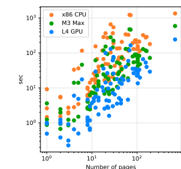
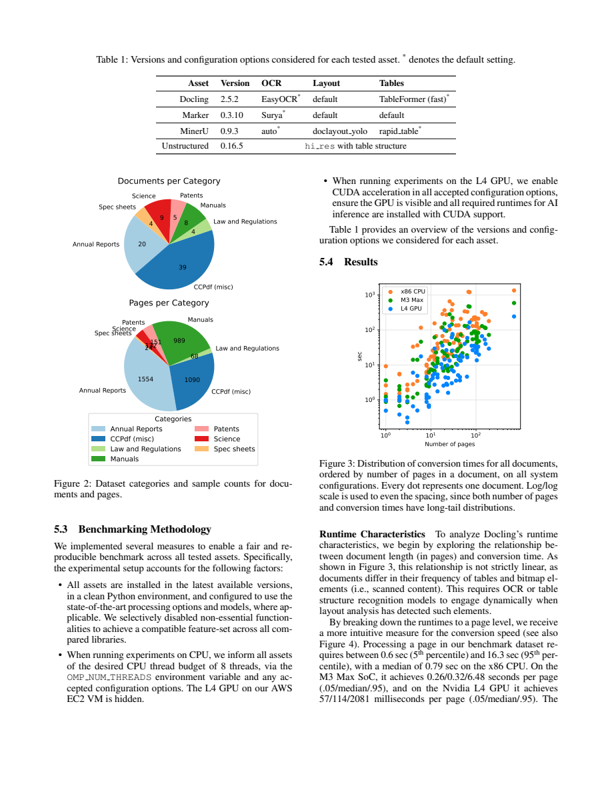

In [5]:
print(doc.export_to_dict())

# print(doc.export_to_html())
# print(doc.export_to_doctags())
# print(doc.export_to_markdown())

## Summarize DoclingDocument Structure

In [6]:
import json

# Create a dictionary with key information from the doc object
doc_summary = {
    "schema_name": doc.schema_name,
    "version": doc.version,
    "name": doc.name,
    "origin": doc.origin.model_dump() if doc.origin else None, # Include origin details
    "furniture_item_count": len(doc.furniture.children) if doc.furniture and hasattr(doc.furniture, 'children') else 0, # Count furniture items
    "body_item_count": len(doc.body.children) if doc.body and hasattr(doc.body, 'children') else 0, # Count body items
    "text_count": len(doc.texts), # Count text items
    "table_count": len(doc.tables), # Count table items
    "picture_count": len(doc.pictures), # Count picture items
    "group_count": len(doc.groups), # Count group items
    # You can add other top-level attributes if needed
    # "metadata": doc.metadata.model_dump() if doc.metadata else None,
}

# Convert the dictionary to a JSON string with indentation for pretty printing
doc_json_summary = json.dumps(doc_summary, indent=4)

print(doc_json_summary)

{
    "schema_name": "DoclingDocument",
    "version": "1.7.0",
    "name": "Document",
    "origin": null,
    "furniture_item_count": 0,
    "body_item_count": 40,
    "text_count": 39,
    "table_count": 1,
    "picture_count": 1,
    "group_count": 1
}


/tmp/ipython-input-4101283766.py:9: DeprecationWarning: deprecated
  "furniture_item_count": len(doc.furniture.children) if doc.furniture and hasattr(doc.furniture, 'children') else 0, # Count furniture items


### Exploring Text Elements

In [7]:
display(doc.texts[0].model_dump())

{'self_ref': '#/texts/0',
 'parent': {'cref': '#/body'},
 'children': [],
 'content_layer': <ContentLayer.BODY: 'body'>,
 'label': <DocItemLabel.CAPTION: 'caption'>,
 'prov': [{'page_no': 1,
   'bbox': {'l': 96.696,
    't': 55.440000000000005,
    'r': 515.304,
    'b': 66.528,
    'coord_origin': <CoordOrigin.TOPLEFT: 'TOPLEFT'>},
   'charspan': (0, 108)}],
 'orig': 'Table 1: Versions and configuration options considered for each tested asset. * denotes the default setting.',
 'text': 'Table 1: Versions and configuration options considered for each tested asset. * denotes the default setting.',
 'formatting': None,
 'hyperlink': None}

In [8]:
print("Exploring Text Elements:")
# Iterate through the text items in the document
for i, text_item in enumerate(doc.texts[:10]): # Limit to the first 10 items
    print(f"Text Item {i}:")
    print(f"  Label: {text_item.label}")
    # Print the first 200 characters of the text to avoid overly long output
    print(f"  Text: {text_item.text[:200]}...")
    if hasattr(text_item, 'prov'):
        print(f"  Provenance (first item): Page {text_item.prov[0].page_no}, Bbox: {text_item.prov[0].bbox}")
    print("-" * 20)

Exploring Text Elements:
Text Item 0:
  Label: caption
  Text: Table 1: Versions and configuration options considered for each tested asset. * denotes the default setting....
  Provenance (first item): Page 1, Bbox: l=96.696 t=55.440000000000005 r=515.304 b=66.528 coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>
--------------------
Text Item 1:
  Label: section_header
  Text: Documents per Category...
  Provenance (first item): Page 1, Bbox: l=118.72800000000001 t=177.40800000000002 r=219.096 b=186.91199999999998 coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>
--------------------
Text Item 2:
  Label: text
  Text: Science...
  Provenance (first item): Page 1, Bbox: l=118.72800000000001 t=191.664 r=157.89600000000002 b=201.168 coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>
--------------------
Text Item 3:
  Label: text
  Text: Patents...
  Provenance (first item): Page 1, Bbox: l=178.70399999999998 t=191.664 r=205.632 b=201.168 coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>
----------------

### Exploring Table Elements

In [9]:
print("Exploring Table Elements:")
# Iterate through the table items in the document
for i, table_item in enumerate(doc.tables):
    print(f"Table Item {i}:")
    print(f"  Label: {table_item.label}")
    if hasattr(table_item, 'prov'):
        print(f"  Provenance (first item): Page {table_item.prov[0].page_no}, Bbox: {table_item.prov[0].bbox}")

    # Displaying table data can be complex, here's a simple representation
    if hasattr(table_item, 'data') and hasattr(table_item.data, 'table_cells'):
        print(f"  Number of cells: {len(table_item.data.table_cells)}")
        # You can add code here to extract and display table data more formally (like a DataFrame)
        # as shown in the previous examples.
    print("-" * 20)

Exploring Table Elements:
Table Item 0:
  Label: table
  Provenance (first item): Page 1, Bbox: l=155.448 t=76.032 r=454.104 b=155.232 coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>
  Number of cells: 30
--------------------


### Exploring Picture Elements

In [10]:
print("Exploring Picture Elements:")
# Iterate through the picture items in the document
for i, picture_item in enumerate(doc.pictures):
    print(f"Picture Item {i}:")
    print(f"  Label: {picture_item.label}")
    if hasattr(picture_item, 'prov'):
        print(f"  Provenance (first item): Page {picture_item.prov[0].page_no}, Bbox: {picture_item.prov[0].bbox}")
    # You can add code here to display the image as shown in the previous examples.
    print("-" * 20)

Exploring Picture Elements:
Picture Item 0:
  Label: picture
  Provenance (first item): Page 1, Bbox: l=339.048 t=277.2 r=520.1999999999999 b=446.68799999999993 coord_origin=<CoordOrigin.TOPLEFT: 'TOPLEFT'>
--------------------


## Visualize Bounding Boxes

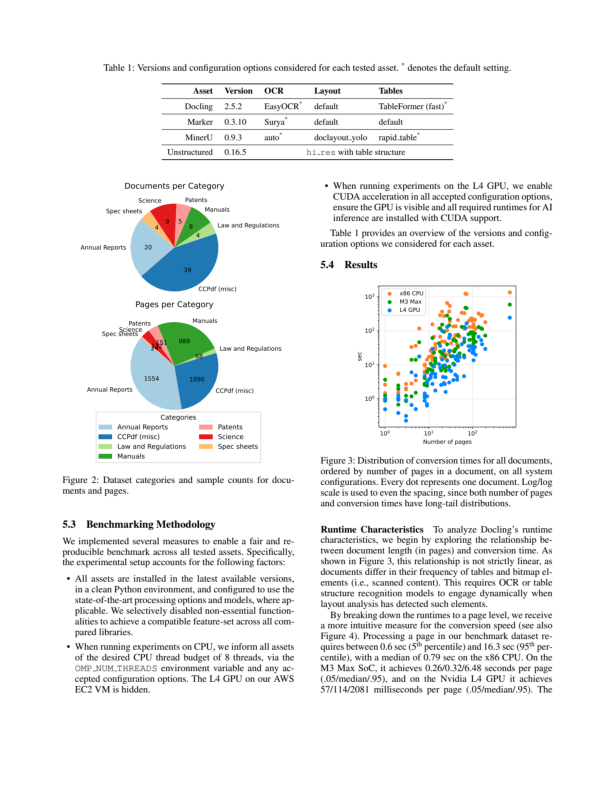

In [12]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import io # Import the io module for handling byte streams

# Assuming the document is a PDF, you might need a way to get an image of a specific page.
# Docling might provide a method for this, or you might need another library like pypdfium2.
# For demonstration, let's assume you have an image file of a page.
# Replace 'path/to/your/page_image.png' with the actual path to your image file.
# If the source is a PDF, you can use pypdfium2 to render a page to an image.

# Example using pypdfium2 (install with !pip install pypdfium2)
import pypdfium2 as pdfium

# Load the PDF document using the local filename
# The local_filename variable is defined in the Document Conversion cell
try:
    pdf = pdfium.PdfDocument(local_filename)
except NameError:
    print("Please run the Document Conversion cell first to define 'local_filename'.")
    pdf = None


if pdf:
    # --- Specify the page number here (0-indexed) ---
    page_index = 4
    # -------------------------------------------------

    page = pdf.get_page(page_index)

    # Render the page to a PdfBitmap and then convert to PIL Image using to_pil()
    bitmap = page.render(scale=2) # Scale up for better resolution
    pil_image = bitmap.to_pil()


    # Create a drawing object
    draw = ImageDraw.Draw(pil_image)

    # Iterate through the elements in the document and draw their bounding boxes
    # You can choose which elements to visualize (e.g., texts, tables, figures)
    # We will check the provenance to ensure the element is on the selected page
    for item in doc.texts + doc.tables + doc.pictures + doc.groups: # Include all relevant item types
        if hasattr(item, 'prov'): # Check if the item has provenance information
            for prov_item in item.prov:
                if prov_item.page_no == page_index + 1: # Check if the provenance item is on the current page (page_no is 1-indexed)
                    bbox = prov_item.bbox
                    # Convert the bbox coordinates to the image's coordinate system (top-left origin)
                    # Docling uses BOTTOMLEFT, Pillow uses TOPLEFT
                    img_width, img_height = pil_image.size

                    # Assuming bbox coordinates are relative to the bottom-left of the page and scaled to 1
                    # You might need to scale the bbox coordinates by the image dimensions
                    # Example:
                    page_width = page.get_width()
                    page_height = page.get_height()
                    scale_x = img_width / page_width
                    scale_y = img_height / page_height

                    top_left_x = bbox.l * scale_x
                    top_left_y = img_height - (bbox.t * scale_y) # Flip y-axis
                    bottom_right_x = bbox.r * scale_x
                    bottom_right_y = img_height - (bbox.b * scale_y) # Flip y-axis


                    # Draw the rectangle
                    # You can customize the color and width based on item type if you want
                    color = "red"
                    if item in doc.tables:
                        color = "blue"
                    elif item in doc.pictures:
                        color = "green"
                    elif item in doc.groups:
                        color = "purple"

                    draw.rectangle([top_left_x, top_left_y, bottom_right_x, bottom_right_y], outline=color, width=2)

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(pil_image)
    plt.axis('off')
    plt.show()

    # Don't forget to close the PDF document
    pdf.close()
else:
    print("Could not load the PDF document.")

## Extract Images and Charts with Associated Text

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pypdfium2 as pdfium # Import pypdfium2

# Get the page index and the rendered image from the previous visualization cell
# Make sure to run the visualization cell first to set these variables
try:
    page_to_extract = page_index + 1 # Convert 0-indexed page_index to 1-indexed page_no
    pil_image_page = pil_image # Use the PIL image of the page from the previous cell
    # Re-obtain the page object within this cell
    pdf = pdfium.PdfDocument(source) # Load the PDF again
    page = pdf.get_page(page_index) # Get the specific page
except NameError:
    print("Please run the visualization cell first to define 'page_index' and generate 'pil_image'.")
    page_to_extract = None
    pil_image_page = None
    page = None # Ensure page is None if previous variables are not set

if page_to_extract is not None and pil_image_page is not None and page is not None:
    print(f"Extracting images and charts from page {page_to_extract}:")
    for item in doc.pictures:
        # Check if the item is on the specified page
        item_on_page = False
        if hasattr(item, 'prov'):
            for prov_item in item.prov:
                if prov_item.page_no == page_to_extract:
                    item_on_page = True
                    bbox = prov_item.bbox # Get the bounding box
                    break # Found provenance on the target page, no need to check further

        if item_on_page:
            print(f"\nFound image or chart:")
            if bbox:
                # Convert the bbox coordinates to the image's coordinate system (top-left origin)
                # Docling uses BOTTOMLEFT, Pillow uses TOPLEFT
                img_width, img_height = pil_image_page.size
                page_width = page.get_width()
                page_height = page.get_height()
                scale_x = img_width / page_width
                scale_y = img_height / page_height

                top_left_x = bbox.l * scale_x
                top_left_y = img_height - (bbox.t * scale_y) # Flip y-axis
                bottom_right_x = bbox.r * scale_x
                bottom_right_y = img_height - (bbox.b * scale_y) # Flip y-axis

                # Crop the image using the bounding box
                try:
                    cropped_img = pil_image_page.crop((top_left_x, top_left_y, bottom_right_x, bottom_right_y))
                    display(cropped_img)

                    # Attempt to find and print associated text
                    associated_text = []
                    if hasattr(item, 'children'):
                        for child_ref in item.children:
                            # Assuming children are text references
                            if child_ref.cref.startswith('#/texts/'):
                                text_index = int(child_ref.cref.split('/')[-1])
                                if text_index < len(doc.texts):
                                    associated_text.append(doc.texts[text_index].text)
                    # Also check for captions attribute if available
                    if hasattr(item, 'captions'):
                        for caption_ref in item.captions:
                              if caption_ref.cref.startswith('#/texts/'):
                                text_index = int(caption_ref.cref.split('/')[-1])
                                if text_index < len(doc.texts):
                                    associated_text.append(doc.texts[text_index].text)

                    if associated_text:
                        print("Associated Text:")
                        for text in associated_text:
                            print(text)
                    else:
                        print("No directly associated text found in children or captions.")


                except Exception as e:
                    print(f"Could not crop or display image: {e}")
            else:
                print("No bounding box found for this image item.")

    # Don't forget to close the PDF document
    pdf.close()
else:
    print("Could not proceed with image extraction because required variables or page object were not available.")

## Extract Table Data

In [ ]:
import pandas as pd

# Get the page index from the previous cell
# Make sure to run the previous cell first to set the page_index variable
try:
    page_to_extract = page_index + 1 # Convert 0-indexed page_index to 1-indexed page_no
except NameError:
    print("Please run the previous cell first to define 'page_index'.")
    page_to_extract = None

if page_to_extract is not None:
    print(f"Extracting tables from page {page_to_extract}:")
    for table_item in doc.tables:
        # Check if the table is on the specified page
        table_on_page = False
        if hasattr(table_item, 'prov'):
            for prov_item in table_item.prov:
                if prov_item.page_no == page_to_extract:
                    table_on_page = True
                    break # Found provenance on the target page, no need to check further

        if table_on_page:
            print(f"\nFound table:")
            # Extract table data into a list of lists
            table_data = []
            if hasattr(table_item, 'data') and hasattr(table_item.data, 'table_cells'):
                # Sort cells by row and then by column for correct order
                sorted_cells = sorted(table_item.data.table_cells, key=lambda cell: (cell.start_row_offset_idx, cell.start_col_offset_idx))

                # Determine the number of rows and columns
                max_row = max(cell.end_row_offset_idx for cell in sorted_cells) if sorted_cells else 0
                max_col = max(cell.end_col_offset_idx for cell in sorted_cells) if sorted_cells else 0

                # Initialize table_data with empty strings
                table_data = [['' for _ in range(max_col)] for _ in range(max_row)]

                # Fill table_data with cell text, considering row and column spans
                for cell in sorted_cells:
                    for r in range(cell.start_row_offset_idx, cell.end_row_offset_idx):
                        for c in range(cell.start_col_offset_idx, cell.end_col_offset_idx):
                            if r < max_row and c < max_col: # Ensure within bounds
                                table_data[r][c] = cell.text

            # Display the table data, for example as a pandas DataFrame
            if table_data:
                try:
                    df = pd.DataFrame(table_data)
                    display(df)
                except Exception as e:
                    print(f"Could not display table as DataFrame: {e}")
                    print("Raw table data:")
                    print(table_data)
            else:
                print("No cells found for this table.")